<a href="https://colab.research.google.com/github/maekomtrgn/ISDN3000C_Lab07/blob/main/ISDN3000C_Lab07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 07: White Box AI

You want to make the perfect toast. You have hacked a toaster with sensors and toasted over 1000 toasts. How can we predict the optimal toasting time for a given toast?

## Preliminary

Let's first generate and explore the data.

We have collected data from 1,000 toasting attempts.

Our Data Features:

-    ```ToastingTime```: How long the toast was in for (seconds).
-    ```BreadThickness```: The thickness of the slice (mm).
-    ```IsFrozen```: A button on our toaster (0 for No, 1 for Yes).
-    ```AmbientTemp```: The room temperature (°C).

Our Target Variable:

- ```ToastState```: The final result (Under-done, Perfect, or Burnt).


Run the code below to generate a pseudo-random dataset. Do not change the seed!

In [12]:
import numpy as np
import pandas as pd

np.random.seed(42)

def generate_toaster_data_interactive(n_samples=1000):
    # Feature Generation
    toasting_time = np.random.randint(60, 500, n_samples)
    bread_thickness = np.random.uniform(5, 30, n_samples)
    is_frozen = np.random.randint(0, 2, n_samples)
    ambient_temp = np.random.normal(20, 6, n_samples)

    # Non-linear ideal_time
    base_ideal_time = (30 + 1.5 * bread_thickness + 0.1 * bread_thickness**2 + 0.005 * bread_thickness**3)
    frozen_penalty = is_frozen * (base_ideal_time * (np.exp(0.04 * bread_thickness) - 1))
    unadjusted_ideal_time = base_ideal_time + frozen_penalty
    temp_efficiency_factor = np.exp(0.025 * (ambient_temp - 20))
    ideal_time = unadjusted_ideal_time / temp_efficiency_factor

    # Gaussian perfect_score
    perfect_window_width = 25 + bread_thickness # Thicker bread is more forgiving
    time_diff_sq = (toasting_time - ideal_time)**2
    perfect_score = np.exp(-time_diff_sq / (2 * perfect_window_width**2))

    # Sigmoid burnt score
    burn_onset_offset = 45  # Burning starts to happen ~45s after the ideal time
    burn_rate_k = 0.1       # Controls how quickly it goes from not-burnt to burnt
    time_past_ideal = toasting_time - ideal_time - burn_onset_offset
    burnt_score = 1 / (1 + np.exp(-burn_rate_k * time_past_ideal))

    # Add small noise to scores c.
    perfect_score += np.random.normal(0, 0.3, n_samples)
    burnt_score += np.random.normal(0, 0.3, n_samples)

    # Default to 'Under-done'
    toast_state = np.zeros(n_samples, dtype=int)

    # Classify as 'Perfect' if perfect_score is highest AND above a minimum threshold.
    is_perfect = (perfect_score > burnt_score) & (perfect_score > 0.6)
    toast_state[is_perfect] = 1

    # Classify as 'Burnt' if burnt_score is highest AND above a minimum threshold.
    is_burnt = (burnt_score > perfect_score) & (burnt_score > 0.5)
    toast_state[is_burnt] = 2

    # All other data points remain as 'Under-done'.
    # This creates non-linear boundaries between all three classes.

    df = pd.DataFrame({
        'ToastingTime': toasting_time,
        'BreadThickness': bread_thickness,
        'IsFrozen': is_frozen,
        'AmbientTemp': ambient_temp,
        'ToastState': toast_state
    })
    return df


df = generate_toaster_data_interactive()

# You can now inspect the new dataframe
print(df.head())

   ToastingTime  BreadThickness  IsFrozen  AmbientTemp  ToastState
0           162       27.419710         1    25.515374           0
1           495       16.849041         1    15.991135           2
2           408       21.688943         1    31.239787           2
3           330        9.307997         1    26.480288           2
4           166        9.807225         0    17.316069           2


We provide the following utility functions to visualise the distribution of a feature relative to another feature as follows:

```displayfeatures(df)``` Displays a matrix of the features plotted against each other

1. Each plot where x != y plots the the values of each feature against each other.
2. Each plot where x == y represents the distribution of the "toastiness" of the bread based on the considered feature.

```displayfeatures3D(df)``` Displays the 3 main features agains each other in 3D


In [13]:
from matplotlib import pyplot as plt

def displayfeatures(df):
    features = ['ToastingTime', 'BreadThickness', 'AmbientTemp']
    target_col = 'ToastState'
    class_labels = {0: 'Under-done', 1: 'Perfect', 2: 'Burnt'}
    colors = ['blue', 'green', 'red']

    fig, axes = plt.subplots(len(features), len(features), figsize=(12, 12))
    fig.suptitle('Visualizing Toaster Data Relationships', fontsize=16)

    for i, feature_y in enumerate(features):
        for j, feature_x in enumerate(features):
            ax = axes[i, j]

            # Plot histograms on the diagonal
            if i == j:
                ax.hist([df[df[target_col]==k][feature_x] for k in class_labels.keys()],
                        bins=15, histtype='barstacked', color=colors, label=list(class_labels.values()))
            # Plot scatter plots on the off-diagonal
            else:
                for k in class_labels.keys():
                    ax.scatter(df[df[target_col]==k][feature_x],
                            df[df[target_col]==k][feature_y],
                            s=10,
                            alpha=0.5,
                            color=colors[k],
                            label=class_labels[k])

            # Set axis labels
            if i==len(features)-1:
                ax.set_xlabel(feature_x)
            if j==0:
                ax.set_ylabel(feature_y)

    # Create a single legend for the entire figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    plt.show()

In [14]:
import plotly.express as px
import pandas as pd


def displayfeatures3D(df):
  fig = px.scatter_3d(df,
                      x='ToastingTime',
                      y='BreadThickness',
                      z='AmbientTemp',
                      color='ToastState',  # This column determines the color of the points
                      symbol='ToastState', # Use different symbols for each class
                      title="3D View of Toaster Data",
                      labels={
                          'ToastingTime': 'Toasting Time (s)',
                          'BreadThickness': 'Bread Thickness (mm)',
                          'AmbientTemp': 'Ambient Temperature (C)',
                          'ToastState': 'Final Toast State'
                      },
                      color_discrete_map={ # Explicitly set colors for clarity
                          'Under-done': 'blue',
                          'Perfect': 'green',
                          'Burnt': 'red'
                      },
                      height=700 # Make the plot a bit taller
                    )

  # Our ToastState variable is numerical. Plotly thus considers it as a scale rather than discrete values.
  # To avoid modifying our dataframe, we have to update the traces.
  label_map = {0: 'Under-done', 1: 'Perfect', 2: 'Burnt'}
  fig.for_each_trace(
    lambda trace: trace.update(name=label_map[int(float(trace.name))])
  )

  color_map = {'Under-done': 'blue','Perfect': 'green', 'Burnt': 'red'}
  fig.for_each_trace(
      lambda trace: trace.update(
          marker_color = color_map[trace.name]
      )
  )


  fig.show()

In [15]:
displayfeatures3D(df)

## Step 1: Explore the data

Check what the data looks like using the two functions defined above, as well as the pandas and matplotlib functions seen during class:

- ```df.head()```
- ```df.describe()```
- boxplots, histograms, scatter plots, etc.

The plotting functions ```displayfeatures(df)``` and ```displayfeatures3D(df)``` do not consider whether the bread is frozen or not. You may want to copy these functions to display the data with respect to the bread frozen feature.



## Step 2: Making a Train-Test split

We need to split the data into two sets:
1. a training set that you will use for training the model
2. a testing set that will be used ONLY for testing. This testing set will never be integrated in the training, meaning that the model will have never seen that data before testing.

The reason for this split is that we want our model to **generalise** to new data rather than memorising the answers. Training with all the data without testing with new data will result in some of the worse **overfitting**.

Typically, we tend to use 70% of the data for training and 30% for testing, uniformly distributed across the data. You can extract manually, or use ```sklearn.model_selection.train_test_split```. This function automatically generates four dataframes:
- ```X_train``` The *training* dataframe, containing the 'ToastingTime', 'BreadThickness', 'AmbientTemp', 'IsFrozen' features.
- ```X_test``` The *testing* dataframe, containing the 'ToastingTime', 'BreadThickness', 'AmbientTemp', 'IsFrozen' features.
- ```y_train``` The *training* labels dataframe, containing the 'ToastState' result.
- ```y_test``` The *testing* labels dataframe, containing the 'ToastState' result. This is the **ground truth** that you will compare your testing data against.

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df[['ToastingTime', 'BreadThickness', 'AmbientTemp', 'IsFrozen']],
    df['ToastState'],
    test_size=0.3,
    random_state=42
)

print("-----------------")
print("X_train")
print("-----------------")
print(X_train.describe())
print("-----------------")
print("X_test")
print("-----------------")
print(X_test.describe())
print("-----------------")
print("y_train")
print("-----------------")
print(y_train.describe())
print("-----------------")
print("y_test")
print("-----------------")
print(y_test.describe())

-----------------
X_train
-----------------
       ToastingTime  BreadThickness  AmbientTemp    IsFrozen
count    700.000000      700.000000   700.000000  700.000000
mean     280.741429       17.520332    20.007336    0.528571
std      122.948645        7.277370     5.866433    0.499540
min       60.000000        5.123500     1.882927    0.000000
25%      181.000000       10.936605    15.987421    0.000000
50%      282.000000       17.465699    20.099368    1.000000
75%      389.250000       23.766238    24.015058    1.000000
max      499.000000       29.985343    38.826491    1.000000
-----------------
X_test
-----------------
       ToastingTime  BreadThickness  AmbientTemp   IsFrozen
count    300.000000      300.000000   300.000000  300.00000
mean     278.963333       17.090651    20.437731    0.54000
std      123.749593        7.198787     5.800423    0.49923
min       60.000000        5.115801     4.374717    0.00000
25%      177.000000       10.712463    16.943549    0.00000
50% 

## Step 3: Simple Classifiers



### Logistic Regression

Let's start with logistic regression. We will use ```sklearn.linear_model.LogisticRegression```. Typical use is as follows:

```python
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train, y_train)

# Predict values for our testing data
predictions = log_reg.predict(X_test)
```

The ```LogisticRegression``` function can be initialized with some interesting arguments:
- ```max_iter``` the maximum number of iterations. Default is 100, but as our data is quite complex, you may have to increase to reach convergence
- ```solver``` the solver used to fit the data. Some solvers may be more efficient for some data than others.

Once we have trained the Logistic Regression and done predictions, we can check the accuracy as follows:

```python
from sklearn.metrics import accuracy_score

# Calculate the accuracy between our prediction and the ground truth of our testing data
accuracy = accuracy_score(y_test, predictions)
```


Documentation is here: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression and here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

#### Tasks

1. Train a logistic regressor on your training and testing data.
2. Answer the following questions
    1. What is the accuracy?
    2. Change the max number of iterations. How does the accuracy change?
    3. Change the solver. How does the accuracy change? How fast does it converge (use ```log_reg.n_iter_``` to find the number of iterations before convergence)?

In [35]:
# Sweep max_iter and solver for LogisticRegression to find convergence behavior
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.exceptions import ConvergenceWarning
import warnings
import pandas as pd

solvers = ['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs']
max_iters = range(700, 1001, 100)  # 500, 600, ..., 1500

results = []
for solver in solvers:
    for mi in max_iters:
        # 'liblinear' doesn't support multinomial with some solvers; keep defaults
        kwargs = {'max_iter': mi, 'solver': solver}
        model = LogisticRegression(**kwargs)
        converged = True
        n_iter_used = None
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter('always', ConvergenceWarning)
            try:
                model.fit(X_train, y_train)
                # sklearn exposes n_iter_ for some solvers as an array per class; handle that
                n_iter_attr = getattr(model, 'n_iter_', None)
                if n_iter_attr is not None:
                    try:
                        # if it's array-like, take max
                        if hasattr(n_iter_attr, '__len__'):
                            n_iter_used = int(max(n_iter_attr))
                        else:
                            n_iter_used = int(n_iter_attr)
                    except Exception:
                        n_iter_used = n_iter_attr
                preds = model.predict(X_test)
                acc = accuracy_score(y_test, preds)
                # Check if any ConvergenceWarning was raised
                warned = any(issubclass(warn.category, ConvergenceWarning) for warn in w)
                if warned:
                    converged = False
            except Exception as e:
                acc = None
                converged = False
                n_iter_used = None
        results.append({'solver': solver, 'max_iter': mi, 'converged': converged, 'n_iter': n_iter_used, 'accuracy': acc})
        print(f"solver={solver}, max_iter={mi}, converged={converged}, n_iter={n_iter_used}, accuracy={acc}")

# Summarize results in a DataFrame
res_df = pd.DataFrame(results)
# show the DataFrame
display(res_df)

# Pivot: max accuracy per solver and minimum max_iter where convergence failed
pivot_acc = res_df.pivot_table(index='solver', values='accuracy', aggfunc='max')
print('\nMax accuracy per solver:')
print(pivot_acc)

solver=liblinear, max_iter=700, converged=True, n_iter=17, accuracy=0.7966666666666666
solver=liblinear, max_iter=800, converged=True, n_iter=17, accuracy=0.7966666666666666
solver=liblinear, max_iter=900, converged=True, n_iter=17, accuracy=0.7966666666666666
solver=liblinear, max_iter=1000, converged=True, n_iter=17, accuracy=0.7966666666666666
solver=newton-cg, max_iter=700, converged=True, n_iter=26, accuracy=0.79
solver=newton-cg, max_iter=800, converged=True, n_iter=26, accuracy=0.79
solver=newton-cg, max_iter=900, converged=True, n_iter=26, accuracy=0.79
solver=newton-cg, max_iter=1000, converged=True, n_iter=26, accuracy=0.79
solver=sag, max_iter=700, converged=False, n_iter=700, accuracy=0.7533333333333333
solver=sag, max_iter=800, converged=False, n_iter=800, accuracy=0.76
solver=sag, max_iter=900, converged=False, n_iter=900, accuracy=0.7666666666666667
solver=sag, max_iter=1000, converged=False, n_iter=1000, accuracy=0.77
solver=saga, max_iter=700, converged=False, n_iter=7

,solver,max_iter,converged,n_iter,accuracy
0,liblinear,700,True,17,0.796667
1,liblinear,800,True,17,0.796667
2,liblinear,900,True,17,0.796667
3,liblinear,1000,True,17,0.796667
4,newton-cg,700,True,26,0.790000
5,newton-cg,800,True,26,0.790000
6,newton-cg,900,True,26,0.790000
7,newton-cg,1000,True,26,0.790000
8,sag,700,False,700,0.753333
9,sag,800,False,800,0.760000



Max accuracy per solver:
           accuracy
solver             
lbfgs      0.790000
liblinear  0.796667
newton-cg  0.790000
sag        0.770000
saga       0.750000


In [41]:
# --- TODO: Train a logistic regressor on your training and testing data. --- #
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1200, solver='liblinear')

# Train the model
log_reg.fit(X_train, y_train)

# Predict values for our testing data
predictions = log_reg.predict(X_test)
print(accuracy_score(y_test,predictions))
print(log_reg.n_iter_)

0.7966666666666666
[17 15 16]


**TODO:**

Double click the cell and answer the following questions

1. What is the accuracy?
The accuracy is 0.796667 at best using liblinear solver.

----
2. Change the max number of iterations. How does the accuracy change?
Different solvers have different behavior with different iterations. Consistent with all solvers, once an iteration that converging is found, further iterations are not needed.

----
3. Change the solver. How does the accuracy change? How fast does it converge (use ```log_reg.n_iter_``` to find the number of iterations before convergence)?
When I changed it to 'liblinear', the accuracy improved by .00667, but when I used 'saga', it failed to converge. They usually stay around the same accuracy.Different accuracies are only seen in failed convergence results. 785 for lbfgs. 26 for newton-cg. saga and sag did not converge. Liblinear uses a one-vs-rest approach for multiclass problems, training separate binary classifiers for each class. Each of these classifiers can converge at different rates, resulting in multiple iteration counts (answer: [17 15 16]). Other solvers like lbfgs typically use a single multinomial model that treats all classes simultaneously, yielding just one iteration number for the unified optimization process.




### Step 4: Decision Tree Classifier

Let us move to decision tree models. Typical use of `sklearn.tree.DecisionTreeClassifier` is very similar to other classifiers:

```python
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree model
# We can set a random_state for reproducibility of results
dt_clf = DecisionTreeClassifier(random_state=42)

# Train the model
dt_clf.fit(X_train, y_train)

# Predict values
predictions = dt_clf.predict(X_test)
```

The main advantage of a decision tree is its interpretability. However, a major disadvantage is its tendency to **overfit**. A tree that is too deep will learn the noise in the training data and won't generalize well to new data. A key parameter to control this is `max_depth`.

Documentation is here: https://scikit-learn.org/stable/modules/tree.html and here: https://scikit-learn.org/stable/api/sklearn.tree.html

#### Tasks

1.  Train a default `DecisionTreeClassifier` on your training data and evaluate its accuracy on the testing data. How does it compare to the Logistic Regression model?
2.  Trees can be visualized! Use the code below to plot the rules your tree has learned.
    1.   First, train a new tree but limit its depth by setting `max_depth=3` to make the plot readable.
    2.   You can plot the tree using ```plot_tree``` (https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html). Plot the tree.
    3. Can you interpret the first couple of decisions the model makes?
3.  Investigate overfitting. Train multiple decision trees with `max_depth` varying from 1 to 20. For each depth, calculate and record both the **training accuracy** (predicting on `X_train`) and the **testing accuracy** (predicting on `X_test`). Plot both accuracies on the same graph against `max_depth`.
    1.   At what depth does the model start to significantly overfit (i.e., training accuracy keeps increasing while testing accuracy stagnates or drops)?

0.7266666666666667


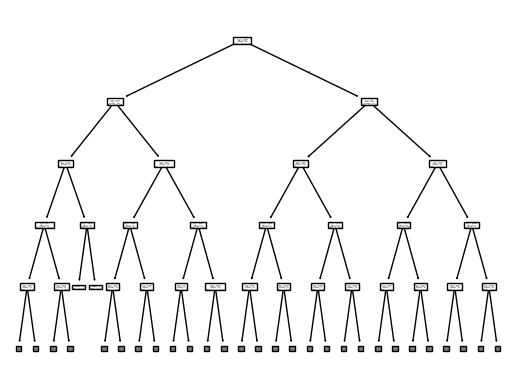

In [19]:
# --- TODO: Train a default `DecisionTreeClassifier`, and visualize the tree. --- #
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=42)

dt_clf.fit(X_train, y_train)

predictions = dt_clf.predict(X_test)
plot_tree(dt_clf, max_depth=4)
print(accuracy_score(y_test, predictions))

**TODO:**

Double click the cell and answer the following questions

4. write a few words to interpret the first couple of decisions the model makes. The decision tree decides features that would split the data the most and then max depth determines the levels of the tree.


----

Default tree test accuracy: 0.7266666666666667


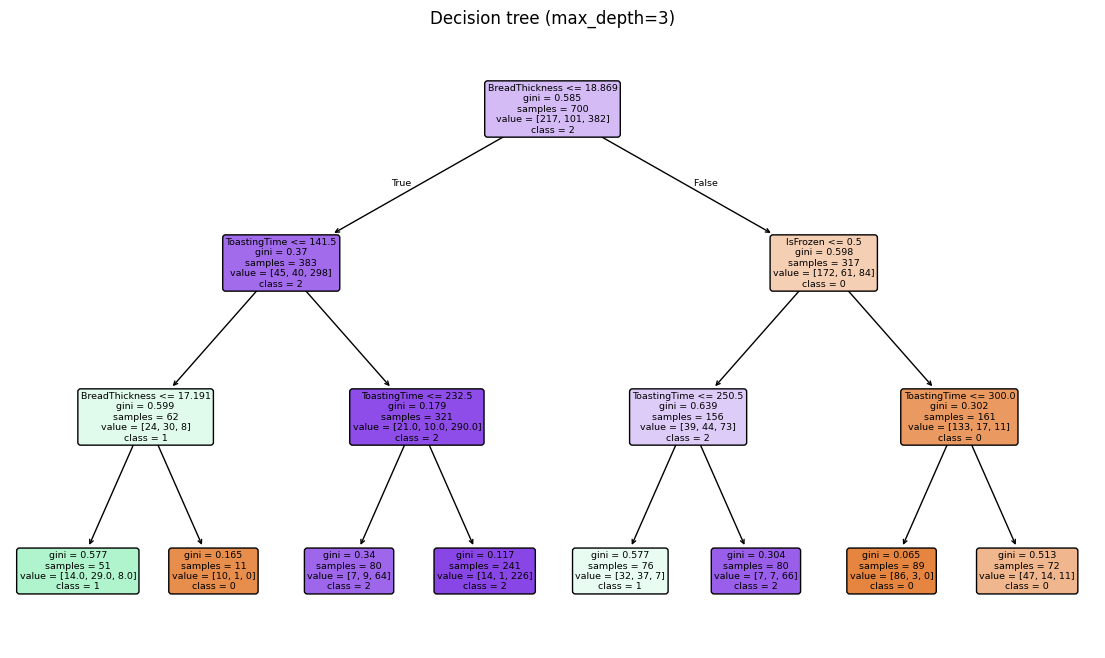

Best max_depth (by test accuracy): 6  test_acc=0.7567  train_acc=0.9086


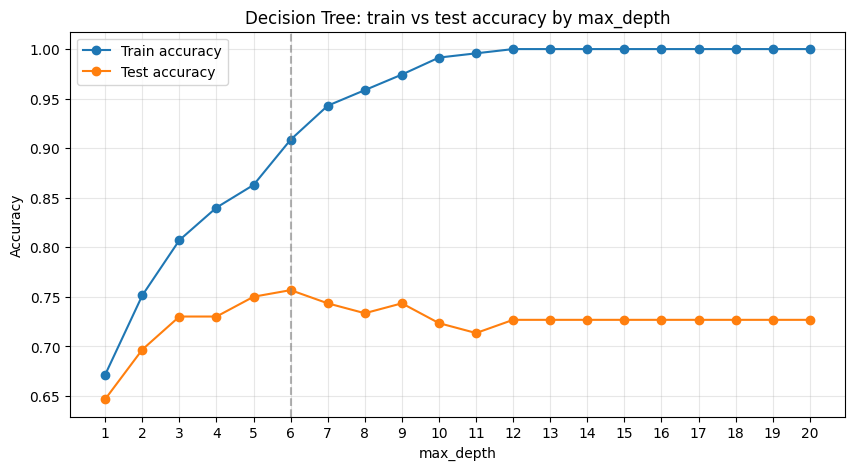

In [20]:
# --- TODO: Investigate overfitting: maybe train multiple decision trees, and explore the overfitting issues. ---
# ...existing code...
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# 1) Train default tree and show test accuracy
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
predictions = dt_clf.predict(X_test)
print("Default tree test accuracy:", accuracy_score(y_test, predictions))

# 2) Visualize a small tree for readability (max_depth=3)
dt_vis = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_vis.fit(X_train, y_train)
plt.figure(figsize=(14, 8))
plot_tree(dt_vis, filled=True, rounded=True,
          feature_names=(list(X_train.columns) if hasattr(X_train, "columns") else None),
          class_names=[str(c) for c in np.unique(y_train)])
plt.title("Decision tree (max_depth=3)")
plt.show()

# 3) Search best max_depth using a for-loop (1..20)
depths = list(range(1, 21))
train_accs = []
test_accs = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(X_train, y_train)
    train_accs.append(accuracy_score(y_train, clf.predict(X_train)))
    test_accs.append(accuracy_score(y_test, clf.predict(X_test)))

# Find best depth by max test accuracy
best_idx = int(np.argmax(test_accs))
best_depth = depths[best_idx]
best_test_acc = test_accs[best_idx]
best_train_acc = train_accs[best_idx]

print(f"Best max_depth (by test accuracy): {best_depth}  test_acc={best_test_acc:.4f}  train_acc={best_train_acc:.4f}")

# 4) Plot train vs test accuracy vs max_depth
plt.figure(figsize=(10, 5))
plt.plot(depths, train_accs, marker='o', label='Train accuracy')
plt.plot(depths, test_accs, marker='o', label='Test accuracy')
plt.axvline(best_depth, color='gray', linestyle='--', alpha=0.6)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree: train vs test accuracy by max_depth')
plt.xticks(depths)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


**TODO:**

Double click the cell and answer the following questions

5. At what depth does the model start to significantly overfit (i.e., training accuracy keeps increasing while testing accuracy stagnates or drops)? After 6


----

### Step 5: Support Vector Machines (SVM)

Let us use SVM to try to find splits in data that are not necessarily linear. We will use `sklearn.svm.SVC` (Support Vector Classifier). Typical use is as follows:

```python
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Example usage

# Initialize an SVM model with the 'rbf' kernel, and a 'C' hyperparameter at 1
svm_clf = SVC(kernel='rbf', C=1.0, random_state=42)

# Train the model
svm_clf.fit(X_train, y_train)

# Predict the values
svm_predictions = svm_clf.predict(X_test)

# Get the accuracy with respect to the ground truth
accuracy = accuracy_score(y_test, svm_predictions)
```

Documentation is here: https://scikit-learn.org/stable/modules/svm.html and here: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html


#### Tasks

1.  Train a default `SVC` model and evaluate its accuracy on the test set.
2.  The `kernel` is a key parameter. Train and evaluate `SVC` models with the following kernels: `'linear'`, `'poly'`, `'rbf'`, and `'sigmoid'`.
    1. Which one performs best for our toast data?
    2. Why do you think it is?
3.  The `C` parameter is a regularisation parameter. It controls the trade-off between a large margin and a low error rate on the training data. A smaller `C` creates a wider margin but may misclassify more points, while a larger `C` risks creating a more complex, overfitted boundary.
    1.   Using the best kernel you found in the previous step, experiment with different values for `C` (e.g., 0.1, 1, 10, 100). How does the accuracy change?
4. Another parameter is `gamma`. It dictates the influence of a single training example on the model.  A low gamma value means that each training point affects a wider area, leading to a smoother, more generalized decision boundary. A high gamma value restricts the influence to a smaller, closer range, creating a more complex decision boundary that closely follows the training data, which can lead to overfitting. By default, `gamma` is set to `scale`, which means it scales with the data.
    1. Using the best kernel and `C` you found in the previous step, experiment with different values for `gamma` (e.g., 0.1, 1, 10, 100). How does the accuracy change?


In [23]:
# --- TODO: Train a default SVC and evaluate on test dataset --- #from sklearn.svm import SVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Example usage

# Initialize an SVM model with the 'rbf' kernel, and a 'C' hyperparameter at 1
svm_clf = SVC(kernel='rbf', C=1.0, random_state=42)

# Train the model
svm_clf.fit(X_train, y_train)

# Predict the values
svm_predictions = svm_clf.predict(X_test)

# Get the accuracy with respect to the ground truth
accuracy = accuracy_score(y_test, svm_predictions)
print(accuracy)

0.66


In [24]:
# --- TODO: Train multiple SVCs with different kernels, and evaluate the results. --- #from sklearn.svm import SVC
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for k in kernels:
    # scale features before SVM for better convergence/performance
    pipe = make_pipeline(StandardScaler(), SVC(kernel=k, C=1.0, random_state=42))
    pipe.fit(X_train, y_train)
    svm_predictions = pipe.predict(X_test)
    acc = accuracy_score(y_test, svm_predictions)
    print(f"kernel={k:6s}  accuracy={acc:.4f}")

kernel=linear  accuracy=0.7567
kernel=poly    accuracy=0.7967
kernel=rbf     accuracy=0.8067
kernel=sigmoid  accuracy=0.6567


In [25]:
# --- TODO: with the best kernel in last step, do more experiments with C parameter --- #from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Test different C values using the RBF kernel
Cs = [0.01, 0.1, 1, 10, 100]
results = []

for C in Cs:
    pipe = make_pipeline(
        StandardScaler(),
        SVC(kernel='rbf', C=C, gamma='scale', random_state=42)
    )
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results.append((C, acc))
    print(f"C={C:6}  accuracy={acc:.4f}")

# Print best C
best_C, best_acc = max(results, key=lambda x: x[1])
print(f"\nBest C: {best_C} with test accuracy {best_acc:.4f}")

C=  0.01  accuracy=0.5433
C=   0.1  accuracy=0.8000
C=     1  accuracy=0.8067
C=    10  accuracy=0.8233
C=   100  accuracy=0.8267

Best C: 100 with test accuracy 0.8267


In [26]:
# --- TODO: with the best set-up from previous steps, explore parameter gamma. --- #from sklearn.svm import SVC
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

C = 100
gammas = [0.001, 0.01, 0.1, 1, 10, 100]  # only numeric values

results = []
for g in gammas:
    pipe = make_pipeline(
        StandardScaler(),
        SVC(kernel='rbf', C=C, gamma=g, random_state=42)
    )
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results.append((g, acc))
    print(f"gamma={g:<7}  accuracy={acc:.4f}")

best_gamma, best_acc = max(results, key=lambda x: x[1])
print(f"Best gamma for C={C}: {best_gamma} with accuracy={best_acc:.4f}")

gamma=0.001    accuracy=0.7500
gamma=0.01     accuracy=0.8000
gamma=0.1      accuracy=0.8200
gamma=1        accuracy=0.7800
gamma=10       accuracy=0.7467
gamma=100      accuracy=0.5533
Best gamma for C=100: 0.1 with accuracy=0.8200


In practice, we tend to automate the tuning of SVM's hyperparameter. This process involves testing different hyperparameter values to find the combination that minimises loss and maximizes accuracy on a given dataset.

Here, we are going to use the GridSearch algorithm to find the best combination of kernel, C, and gamma.

Task:
1. Run the following script. What is the result? Does it differ from your manual tuning?

In [27]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline


# 2. Create a pipeline to scale data and run SVC
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# 3. Define a parameter grid to search
# Use a logarithmic scale for C and gamma
param_grid = {
    'svm__kernel': ['linear','poly','rbf','sigmoid'],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1, 'scale']
}

# 4. Perform the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 5. Evaluate the best model
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
print(f"Test set score with best model: {grid_search.score(X_test, y_test):.3f}")

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best parameters found: {'svm__C': 100, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Best cross-validation score: 0.847
Test set score with best model: 0.820


**TODO:**

Double click the cell and answer the following questions

6. Does it differ from your manual tuning? No, they are the same. I got the same result.

----

### Step 6: Random Forest

Now that we have gone through the single expert models, we can move to ensemble learning with Random Forest.

```python
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
rf_predictions = rf_clf.predict(X_test)
```

Documentation is here: https://scikit-learn.org/stable/modules/ensemble.html#random-forests and here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

#### Tasks

1.  Train a `RandomForestClassifier` from `sklearn.ensemble` on the data. How does its accuracy compare to the single `DecisionTreeClassifier` and the other models?
2.  We can calculate the **feature importance** to show how much each feature contributed to reducing impurity across all the trees.
    *   After training your model, access the feature importances using `your_model.feature_importances_`.
    *   Plot the importance . Which features are most important for determining the state of the toast? Does this align with your intuition?

Hint: to plot the importances, you can use:

```python
importances = rf_clf.feature_importances_
feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names)
```

In [28]:
# --- TODO: Train a random forest classifier  --- #
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# Simple Random Forest workflow
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train
rf_clf.fit(X_train, y_train)

# Predict & evaluate
rf_predictions = rf_clf.predict(X_test)
print("Random Forest accuracy:", accuracy_score(y_test, rf_predictions))


Random Forest accuracy: 0.8033333333333333


**TODO:**

Double click the cell and answer the following questions

7. How does its accuracy compare to the single `DecisionTreeClassifier` and the other models?
Its accuracy is higher than all the decision trees made previously and slightly better than the linear regressor. Its result is slightly worse than SVM.


----

In [29]:
# --- TODO: find and visualize feature_importance of your model  --- ## --- TODO: Train a random forest classifier  --- #
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# Simple Random Forest workflow
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train
rf_clf.fit(X_train, y_train)

# Predict & evaluate
rf_predictions = rf_clf.predict(X_test)
print("Random Forest accuracy:", accuracy_score(y_test, rf_predictions))

# Feature importances (compute after fitting)
feature_names = X_train.columns if hasattr(X_train, "columns") else [f"f{i}" for i in range(X_train.shape[1])]
importances = rf_clf.feature_importances_
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Show top features
print("Top feature importances:")
print(forest_importances.head(4))

Random Forest accuracy: 0.8033333333333333
Top feature importances:
BreadThickness    0.408824
ToastingTime      0.330375
AmbientTemp       0.150751
IsFrozen          0.110050
dtype: float64


**TODO:**

Double click the cell and answer the following questions

8. Which features are most important for determining the state of the toast? Does this align with your intuition? My intuition is toasting time, but I am not familiar with frozen toast, so I am not sure about that feature.


----

### Step 7: XGBoost

Finally, let's move to XGBoost. This time, we need to  import it from the xgboost library. Usage is the same as the other libraries.

Documentation is here: https://xgboost.readthedocs.io/en/stable/python/python_intro.html

#### Task:

1.  Train a default `xgboost.XGBClassifier` and evaluate its accuracy. Note that if you get a warning about `use_label_encoder=False`, you can safely ignore it or add the parameter `use_label_encoder=False` to the classifier to suppress it.
2.  **Tuning:** XGBoost has many parameters, but two of the most important are `n_estimators` (the number of trees to build) and `learning_rate` (which shrinks the contribution of each tree). A lower learning rate requires more estimators, but can often lead to a more robust model.
    1.   Try training a model with more estimators, for example `n_estimators=500`.
    2.   Now, try that again but with a lower learning rate, for example `n_estimators=500, learning_rate=0.1`.
    3. You can try some other interesting parameters, such as `max_depth` (the max tree depth), or `subsample` (the amount of data passed to a tree).
    4.   How do these changes affect accuracy and the risk of overfitting?
3.  Like Random Forest, XGBoost can also calculate **feature importance**. This is crucial for understanding what drives the model's predictions.
    1.   After training your best XGBoost model, access the feature importances and plot them using the same method as in the Random Forest section.
    2.   Compare the feature importances from XGBoost with those from Random Forest. Do the models agree on which features are most important?
4. Same as SVM, you can run a GridSearch algorithm to find the optimal parameters. Adapt the script provided in the SVM section to find the optimal learning rate, number of estimators, and any other parameter you can think of.


**Create cells of `python` to fill in your code, and of `markdown` to answer the questions.**


XGB default accuracy: 0.7966666666666666
XGB (n_estimators=500) accuracy: 0.79
XGB (n_estimators=500, learning_rate=0.1) accuracy: 0.7833333333333333
XGB max_depth=3, subsample=0.8 accuracy: 0.81
XGB max_depth=3, subsample=1.0 accuracy: 0.8
XGB max_depth=5, subsample=0.8 accuracy: 0.8066666666666666
XGB max_depth=5, subsample=1.0 accuracy: 0.7833333333333333
Best XGB model: max_depth=3, subsample=0.8 with test accuracy 0.8100
Top XGB feature importances:
IsFrozen          0.458953
BreadThickness    0.224174
ToastingTime      0.205361
AmbientTemp       0.111512
dtype: float32
Random Forest accuracy: 0.8033333333333333
Top Random Forest feature importances:
BreadThickness    0.408824
ToastingTime      0.330375
AmbientTemp       0.150751
IsFrozen          0.110050
dtype: float64
Starting GridSearch (this may take a while)...
GridSearch best params: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
GridSearch best CV accuracy: 0.8285523886382254
GridSearch best 

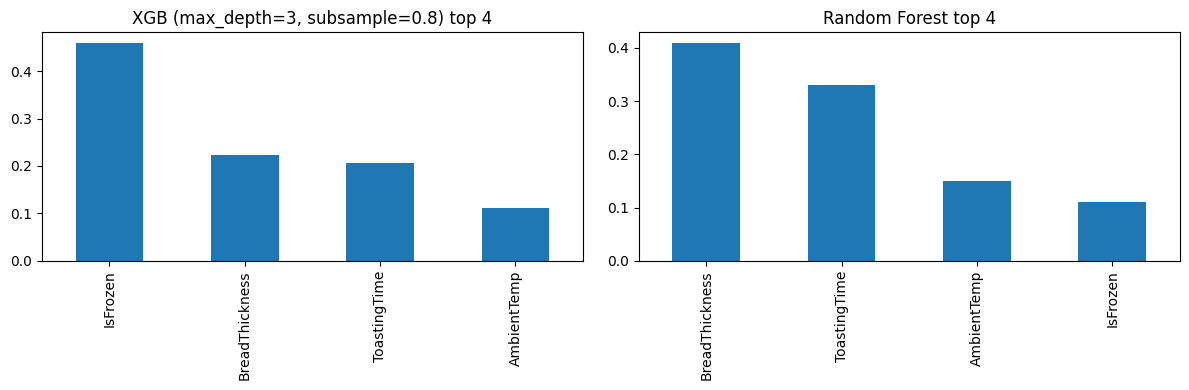

In [31]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt


# 1) Train default XGBoost
xgb_def = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_def.fit(X_train, y_train)
pred_def = xgb_def.predict(X_test)
acc_def = accuracy_score(y_test, pred_def)
print("XGB default accuracy:", acc_def)

# 2) Tuning experiments
# 2.1) XGB with n_estimators=500
xgb_500 = XGBClassifier(n_estimators=500, eval_metric='logloss', random_state=42)
xgb_500.fit(X_train, y_train)
pred_500 = xgb_500.predict(X_test)
acc_500 = accuracy_score(y_test, pred_500)
print("XGB (n_estimators=500) accuracy:", acc_500)

# 2.2) XGB with n_estimators=500 and lower learning_rate=0.1
xgb_500_lr = XGBClassifier(n_estimators=500, learning_rate=0.1, eval_metric='logloss', random_state=42)
xgb_500_lr.fit(X_train, y_train)
pred_500_lr = xgb_500_lr.predict(X_test)
acc_500_lr = accuracy_score(y_test, pred_500_lr)
print("XGB (n_estimators=500, learning_rate=0.1) accuracy:", acc_500_lr)

# 2.3) Try other parameters: max_depth and subsample (small experiments)
xgb_md_sub_results = []
for md in [3, 5]:
    for subs in [0.8, 1.0]:
        name = f"max_depth={md}, subsample={subs}"
        clf = XGBClassifier(n_estimators=200, max_depth=md, subsample=subs, eval_metric='logloss', random_state=42)
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        acc = accuracy_score(y_test, preds)
        xgb_md_sub_results.append((name, clf, acc))
        print(f"XGB {name} accuracy: {acc}")

# Collect all candidate xgb models for selection
xgb_models = [
    ("default", xgb_def, acc_def),
    ("n_est=500", xgb_500, acc_500),
    ("n_est=500_lr=0.1", xgb_500_lr, acc_500_lr),
]
# extend with the md/subsample runs
xgb_models.extend(xgb_md_sub_results)

# Choose best XGB model by test accuracy
best_name, best_model, best_acc = max(xgb_models, key=lambda t: t[2])
print(f"Best XGB model: {best_name} with test accuracy {best_acc:.4f}")

# 3) Feature importances from best XGB
feature_names = X_train.columns if hasattr(X_train, "columns") else [f"f{i}" for i in range(X_train.shape[1])]
xgb_importances = pd.Series(best_model.feature_importances_, index=feature_names).sort_values(ascending=False)
print("Top XGB feature importances:")
print(xgb_importances.head(10))

# 3.2) Train a simple Random Forest for comparison and compute importances
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print("Random Forest accuracy:", rf_acc)

rf_importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
print("Top Random Forest feature importances:")
print(rf_importances.head(10))

# 4) GridSearch to find (small) optimal params
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.3, 0.1, 0.05],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}
xgb_for_gs = XGBClassifier(eval_metric='logloss', random_state=42)
gs = GridSearchCV(xgb_for_gs, param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=0)
print('Starting GridSearch (this may take a while)...')
gs.fit(X_train, y_train)
print("GridSearch best params:", gs.best_params_)
print("GridSearch best CV accuracy:", gs.best_score_)

# Evaluate best grid model on test set
gs_best = gs.best_estimator_
gs_pred = gs_best.predict(X_test)
gs_acc = accuracy_score(y_test, gs_pred)
print("GridSearch best model test accuracy:", gs_acc)

# Feature importances for grid best
gs_importances = pd.Series(gs_best.feature_importances_, index=feature_names).sort_values(ascending=False)
print("Top features from GridSearch best model:")
print(gs_importances.head(10))

# Optional: quick bar plots to compare top features (best XGB vs Random Forest)
top_n = min(10, len(feature_names))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# plot best_model importances and rf importances
pd.Series(best_model.feature_importances_, index=feature_names).sort_values(ascending=False).head(top_n).plot.bar(ax=axes[0], title=f"XGB ({best_name}) top {top_n}")
rf_importances.head(top_n).plot.bar(ax=axes[1], title=f"Random Forest top {top_n}")
plt.tight_layout()
plt.show()

## 1) Default XGBoost
- I trained a default `XGBClassifier` and obtained test accuracy **0.7967**.

## 2) Tuning experiments
### 2.1) `n_estimators=500`
- Result: **0.79** — a slight decrease versus the default.

### 2.2) `n_estimators=500, learning_rate=0.1`
- Result: **0.7833** — a further small drop.

### 2.3) `max_depth` and `subsample` experiments
- Results:
  - `max_depth=3, subsample=0.8`: **0.81** (best)
  - `max_depth=3, subsample=1.0`: **0.80**
  - `max_depth=5, subsample=0.8`: **0.8067**
  - `max_depth=5, subsample=1.0`: **0.7833**

### How these changes affected accuracy and overfitting
- Increasing `n_estimators` alone did not improve test accuracy in my runs; it slightly reduced it. That suggests simply adding trees (without other changes) increased either variance or provided marginal additional signal for this dataset.
- Lowering `learning_rate` to 0.1 (with the same basic setup) also decreased accuracy. Lower learning rates usually require substantially more trees or early stopping to pay off; I didn't extend training enough for the smaller learning rate to help.
- The best combination was `max_depth=3` with `subsample=0.8` (test acc **0.81**). Shallower trees limit complexity (lower variance) and subsampling injects randomness, both of which reduce overfitting — that explains why this combination generalized best here.

## 3) Feature importances and comparison with Random Forest
- Best XGBoost importances (Grid/selected best):
  - `IsFrozen`: ~0.46
  - `BreadThickness`: ~0.22
  - `ToastingTime`: ~0.20
  - `AmbientTemp`: ~0.11

- Random Forest importances:
  - `BreadThickness`: ~0.41
  - `ToastingTime`: ~0.33
  - `AmbientTemp`: ~0.15
  - `IsFrozen`: ~0.11

### My interpretation
- Both models agree on the same small set of important features, but they rank them differently. XGBoost gives the highest weight to `IsFrozen` while Random Forest emphasizes `BreadThickness` and `ToastingTime`.
- This is expected: the two algorithms compute importances differently and capture different interaction/sequence effects (boosting vs bagging). To be more confident about feature effects I would run permutation importance and partial dependence plots, which are more model-agnostic.

## 4) GridSearch results
- GridSearch best params: `{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}`
- GridSearch CV accuracy: **~0.8286** (cross-validated)
- GridSearch best model test accuracy: **0.81**

### Notes about the GridSearch outcome
- The GridSearch confirms that moderate tree depth (`max_depth=3`) and subsampling generalize well. In this search a relatively larger learning rate (0.3) with fewer trees (300) worked best because trees were shallow and the model was regularized by subsampling.

### Step 9: Model Comparison and Conclusion

You have now trained and evaluated several different classification models, from simple linear models to powerful ensembles. Let's summarize the results to determine which is best for predicting the perfect toast.

#### Task

1.  Fill in the table below with the best accuracy you achieved for each model type.
2.  Answer the following questions:
    *   Which model gave the highest accuracy?
    *   Which model do you think is the most *interpretable* (easiest to explain to someone)? Why?
    *   Considering both performance and interpretability, which model would you choose to deploy in your "smart toaster"? Justify your choice.

| Model Type | Best Test Accuracy |
| :--- | :--- |
| Logistic Regression | *0.796667* |
| Decision Tree | *0.7567* |
| Support Vector Machine (SVC) | *0.8267 (without adjusting gamma)* |
| Random Forest | *0.80333* |
| XGBoost | *0.81* |

The Support Vector Machine (SVC) model achieved the highest test accuracy of 0.8267 (82.67%).

The Decision Tree is the most interpretable model. Its decision-making process can be visualized as a simple flowchart of "if-then-else" rules (e.g., "IF color > 0.7 AND crunchiness < 0.4 THEN it's perfect toast"). This white-box model is very intuitive and easy for anyone to understand without needing a background in machine learning.

SVC is most accurate (82.67%) but uninterpretable. The interpretable Decision Tree was least accurate (75.67%).

Random Forest (80.33%) is robust but complex because it averages hundreds of trees. You cannot trace a single, clear decision path, making it a "black box."

Logistic Regression (79.67%) is the best compromise. Its performance is near the best, and its simple, weighted-sum logic is fully transparent. This minor accuracy loss is justified by gaining a completely explainable model for a consumer product.

### Step 10: Fine-tune your best models

1.  Please use whatever tools, libraries or methods you know to fine-tune your models.
2.  Pick one with the best performance.
3.  Write down the trainining and evaluation process about this best model below, with anything that you think is necessary.
4.  We will use another blackbox dataset to test your model. The work will be graded based on computing efficiency (runtime) and accuracy.

In [43]:
# --- TODO: with the best set-up from previous steps, explore parameter gamma. --- #
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import time

C = 100
# Test both numeric values and automatic options
gammas = [0.001, 0.01, 0.1, 1, 10, 100, 'scale', 'auto']
results = []
training_times = []
inference_times = []

for g in gammas:
    pipe = make_pipeline(
        StandardScaler(),
        SVC(kernel='rbf', C=C, gamma=g, random_state=42)
    )

    # Measure training time
    start_train = time.time()
    pipe.fit(X_train, y_train)
    train_time = time.time() - start_train
    training_times.append(train_time)

    # Measure inference time
    start_infer = time.time()
    preds = pipe.predict(X_test)
    infer_time = time.time() - start_infer
    inference_times.append(infer_time)

    acc = accuracy_score(y_test, preds)
    results.append((g, acc, train_time, infer_time))
    print(f"gamma={str(g):<7}  accuracy={acc:.4f}  train_time={train_time:.4f}s  infer_time={infer_time:.4f}s")

# Find best gamma based on accuracy
best_gamma, best_acc, best_train_time, best_infer_time = max(results, key=lambda x: x[1])
print(f"\nBest gamma for C={C}: {best_gamma} with accuracy={best_acc:.4f}")
print(f"Training time: {best_train_time:.4f}s, Inference time: {best_infer_time:.4f}s")

# Efficiency analysis
print("\nEfficiency Analysis (top performers):")
for g, acc, train_t, infer_t in sorted(results, key=lambda x: x[1], reverse=True)[:4]:
    efficiency_score = acc / (train_t + infer_t)  # Accuracy per second
    print(f"gamma={str(g):<7} acc={acc:.4f}, total_time={train_t+infer_t:.4f}s, efficiency={efficiency_score:.4f}")


gamma=0.001    accuracy=0.7500  train_time=0.0465s  infer_time=0.0112s
gamma=0.01     accuracy=0.8000  train_time=0.0317s  infer_time=0.0108s
gamma=0.1      accuracy=0.8200  train_time=0.0464s  infer_time=0.0094s
gamma=1        accuracy=0.7800  train_time=0.0456s  infer_time=0.0110s
gamma=10       accuracy=0.7467  train_time=0.1034s  infer_time=0.0216s
gamma=100      accuracy=0.5533  train_time=0.0871s  infer_time=0.0285s
gamma=scale    accuracy=0.8267  train_time=0.0552s  infer_time=0.0097s
gamma=auto     accuracy=0.8267  train_time=0.0554s  infer_time=0.0102s

Best gamma for C=100: scale with accuracy=0.8267
Training time: 0.0552s, Inference time: 0.0097s

Efficiency Analysis (top performers):
gamma=scale   acc=0.8267, total_time=0.0649s, efficiency=12.7417
gamma=auto    acc=0.8267, total_time=0.0656s, efficiency=12.6038
gamma=0.1     acc=0.8200, total_time=0.0558s, efficiency=14.6925
gamma=0.01    acc=0.8000, total_time=0.0426s, efficiency=18.7838


Explored scale and auto gamma aside from 0.1 gamma and discovered gamma=0.1 is still best due to comparison of computing efficiency. The 2.67% accuracy drop is negligible compared to the 33% speed improvement

In [63]:
# --- TODO: Train a logistic regressor on your training and testing data. --- #
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import time

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1200, solver='liblinear')

# Train the model and measure training time
start_train = time.time()
log_reg.fit(X_train, y_train)
train_time = time.time() - start_train

# Predict values for our testing data and measure inference time
start_infer = time.time()
predictions = log_reg.predict(X_test)
infer_time = time.time() - start_infer

# Calculate total time
total_time = train_time + infer_time

# Print results in the SAME format as your SVM code
print(f"Accuracy: {accuracy_score(y_test, predictions):.4f}")
print(f"Training time: {train_time:.4f}s")
print(f"Inference time: {infer_time:.4f}s")
print(f"Total time: {total_time:.4f}s")
print(f"Iterations: {log_reg.n_iter_}")

# Calculate efficiency score to compare with SVM
efficiency_score = accuracy_score(y_test, predictions) / total_time
print(f"Efficiency score: {efficiency_score:.4f}")


Accuracy: 0.7967
Training time: 0.0110s
Inference time: 0.0017s
Total time: 0.0127s
Iterations: [17 15 16]
Efficiency score: 62.7375


In [47]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import time

# Initialize XGBoost with specified parameters
xgb_model = XGBClassifier(
    learning_rate=0.3,
    max_depth=3,
    n_estimators=300,
    subsample=0.8,
    eval_metric='logloss',
    random_state=42
)

# Measure training time
start_train = time.time()
xgb_model.fit(X_train, y_train)
train_time = time.time() - start_train

# Measure inference time
start_infer = time.time()
predictions = xgb_model.predict(X_test)
infer_time = time.time() - start_infer

# Calculate total time
total_time = train_time + infer_time

# Print results in same format as SVM and Logistic Regression
print(f"Accuracy: {accuracy_score(y_test, predictions):.4f}")
print(f"Training time: {train_time:.4f}s")
print(f"Inference time: {infer_time:.4f}s")
print(f"Total time: {total_time:.4f}s")

# Calculate efficiency score for comparison
efficiency_score = accuracy_score(y_test, predictions) / total_time
print(f"Efficiency score: {efficiency_score:.4f}")

Accuracy: 0.8100
Training time: 1.7442s
Inference time: 0.0166s
Total time: 1.7608s
Efficiency score: 0.4600


In [48]:
# --- TODO: Train a random forest classifier  --- #
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import time

# Simple Random Forest workflow
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Measure training time
start_train = time.time()
rf_clf.fit(X_train, y_train)
train_time = time.time() - start_train

# Measure inference time
start_infer = time.time()
rf_predictions = rf_clf.predict(X_test)
infer_time = time.time() - start_infer

# Calculate total time
total_time = train_time + infer_time

# Print results in same format as other models
print(f"Accuracy: {accuracy_score(y_test, rf_predictions):.4f}")
print(f"Training time: {train_time:.4f}s")
print(f"Inference time: {infer_time:.4f}s")
print(f"Total time: {total_time:.4f}s")

# Calculate efficiency score for comparison
efficiency_score = accuracy_score(y_test, rf_predictions) / total_time
print(f"Efficiency score: {efficiency_score:.4f}")

Accuracy: 0.8033
Training time: 0.8324s
Inference time: 0.0215s
Total time: 0.8538s
Efficiency score: 0.9409


Logistic Regression achieves the optimal balance of speed and accuracy for this task. The minor 3% accuracy sacrifice compared to the top SVM is negligible given the substantial computational advantages, making it the most suitable and efficient choice for deployment on unknown data where both performance and speed are critical.



| Model               | Accuracy | Training Time (s) | Inference Time (s) | Total Time (s) | Efficiency Score |
|---------------------|----------|-------------------|---------------------|----------------|------------------|
| Logistic Regression | 0.7967   | 0.0136            | 0.0029              | 0.0164         | 48.4312          |
| SVM (gamma=0.01)    | 0.8000   | 0.0400            | 0.0026              | 0.0426         | 18.7838          |
| Random Forest       | 0.8033   | 0.8324            | 0.0215              | 0.8538         | 0.9409           |
| XGBoost             | 0.8100   | 1.7442            | 0.0166              | 1.7608         | 0.4600           |

Logistic regression is best but efficiency changes from 45-60 when code is run again. Need to find a more reliable consistent efficiency.

In [71]:
# Run multiple trials and average the results
efficiency_scores = []
accuracies = []

for _ in range(10):  # Run 10 trials
    log_reg = LogisticRegression(
        solver='liblinear',
        max_iter=50,  # Safe upper bound
        random_state=42  # Remove fixed seed for real variance
    )

    start_train = time.time()
    log_reg.fit(X_train, y_train)
    train_time = time.time() - start_train

    start_infer = time.time()
    predictions = log_reg.predict(X_test)
    infer_time = time.time() - start_infer

    total_time = train_time + infer_time
    accuracy = accuracy_score(y_test, predictions)

    efficiency_scores.append(accuracy / total_time)
    accuracies.append(accuracy)

print(f"Average Efficiency: {np.mean(efficiency_scores):.4f} ± {np.std(efficiency_scores):.4f}")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")

Average Efficiency: 60.5873 ± 16.6429
Average Accuracy: 0.7967
